This notebook is used to postprocessing the inverse modeling results of the cloud chamber model.

In [1]:
# Libraries
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import sys
# sys.path.append('/people/jian449/KIM/src')
from kim.map import KIM
from kim.data import Data
from kim.utils import plot_sensitivity_mask, plot_sensitivity, plot_1to1_scatter, plot_1to1_uncertainty

%load_ext autoreload
%autoreload 2
%matplotlib inline 


# Read the data

In [2]:
# File and folder paths
dir_case = Path("./")
# Training data
dir_data = dir_case / "data-holodec-PoissonPertb"
f_para = dir_data / "Output.csv"
f_state = dir_data / "Input_np_holodec.csv"

# Saving folder
dir_results = dir_case / "results-holodec"


In [3]:
df_para, df_state = pd.read_csv(f_para),pd.read_csv(f_state)
y_vars, x_vars = df_para.keys().to_list(), df_state.keys().to_list()
y, x = df_para.values, df_state.values
y_vars = ['$\lambda_w$', '$\log_{10}(\lambda_c)$']
x.shape, y.shape

<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_128531/2363140426.py:4: SyntaxWarning: invalid escape sequence '\l'
  y_vars = ['$\lambda_w$', '$\log_{10}(\lambda_c)$']
/tmp/ipykernel_128531/2363140426.py:4: SyntaxWarning: invalid escape sequence '\l'
  y_vars = ['$\lambda_w$', '$\log_{10}(\lambda_c)$']


((513, 1458), (513, 2))

# Load the preliminary analysis results

In [4]:
f_data_save = dir_results / "data"
data = Data(x, y)
data.load(f_data_save)


# Plot the sensitivity analysis results

[Text(0.5, 1.0, 'Global sensitivity'),
 Text(85.72222222222221, 0.5, 'Parameters'),
 Text(0.5, 7.722222222222216, 'Model states')]

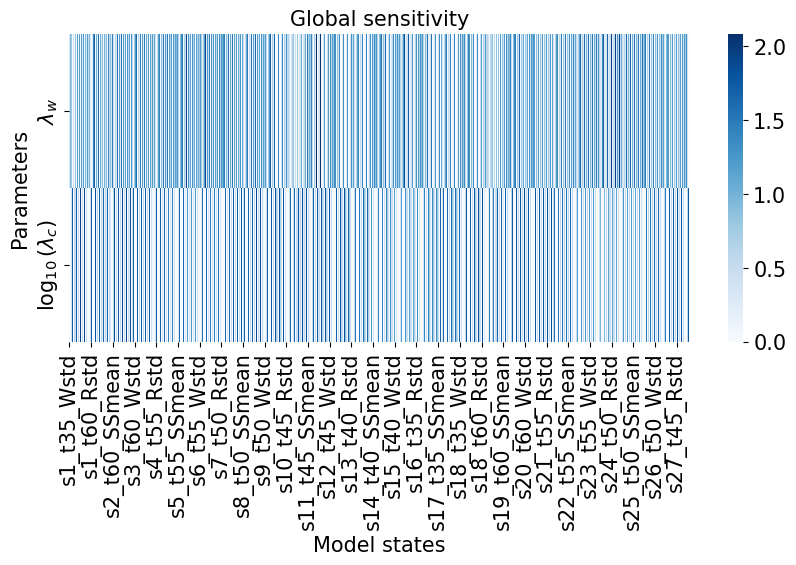

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
plot_sensitivity(data.sensitivity.T, xlabels=y_vars, ylabels=x_vars)
ax.set(title='Global sensitivity using mutual information', ylabel='Parameters', xlabel='Model states')


array([1168,  813])

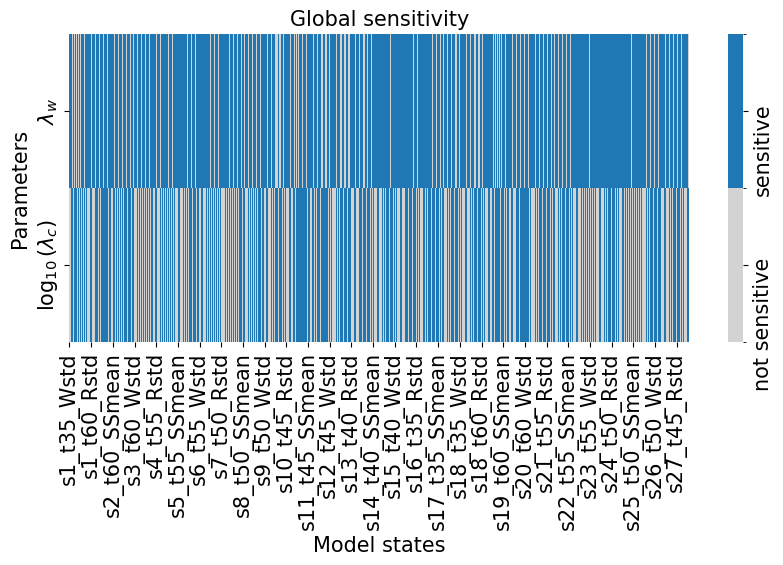

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
plot_sensitivity_mask(data.sensitivity_mask.T, xlabels=y_vars, ylabels=x_vars)
ax.set(title='Global sensitivity', ylabel='Parameters', xlabel='Model states')
data.sensitivity_mask.sum(axis=0)

array([1043,  336])

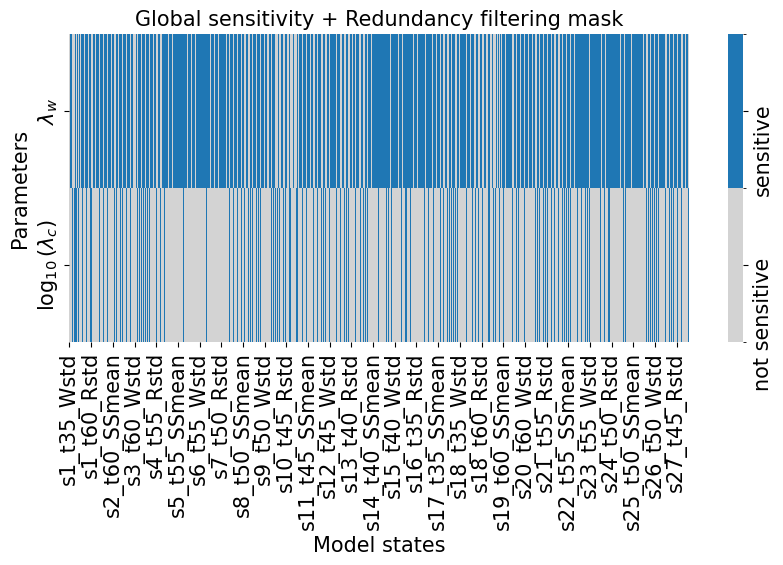

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
plot_sensitivity_mask(data.cond_sensitivity_mask.T, xlabels=y_vars, ylabels=x_vars)
ax.set(title='Global sensitivity + Redundancy filtering mask', ylabel='Parameters', xlabel='Model states')
data.cond_sensitivity_mask.sum(axis=0)


# Load the mapping results

- `kim1`: The naive inverse mapping from all $\mathbf{Y}$ to all $\mathbf{X}$
- `kim2`: The knowledge-informed inverse mapping from sensitive $\mathbf{Y}$ to each of $\mathbf{X}$ using global sensitivity analysis
- `kim3`: The knowledge-informed inverse mapping from sensitive $\mathbf{Y}$ to each of $\mathbf{X}$ using global sensitivity analysis + redundancy filtering check

In [14]:
f_kim_save1 = dir_case / "results-holodec/map_many2many"
f_kim_save2 = dir_case / "results-holodec/map_many2one"
f_kim_save3 = dir_case / "results-holodec/map_many2one_cond"


In [15]:
# Initialize three diffferent KIMs
kim1 = KIM(data, map_configs={}, map_option='many2many')
kim2 = KIM(data, map_configs={}, mask_option="sensitivity", map_option='many2one')
kim3 = KIM(data, map_configs={}, mask_option="cond_sensitivity", map_option='many2one')

# Load the trained mappings
kim1.load(f_kim_save1)
kim2.load(f_kim_save2)
kim3.load(f_kim_save3)


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [16]:
# print(np.mean([loss[-1] for loss in kim1.maps[0].loss_val_ens]))
# print(np.mean([loss[-1] for loss in kim2.maps[0].loss_val_ens]))
# print(np.mean([loss[-1] for loss in kim3.maps[0].loss_val_ens]))
# # kims = [kim1, kim2, kim3]


In [17]:
# Calculate the performance metrics
kims = [kim1, kim2, kim3]
# labels = ['kim1', 'kim2', 'kim3']
labels = ['$M_0$', '$M_1$', '$M_2$']
results = {}
for i,kim in enumerate(kims):
    label = labels[i]
    results[label] = kim.evaluate_maps_on_givendata()


/global/cfs/cdirs/m1800/peishi/.conda/envs/kim/lib/python3.12/site-packages/hydroeval/objective_functions.py:80: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/global/cfs/cdirs/m1800/peishi/.conda/envs/kim/lib/python3.12/site-packages/hydroeval/objective_functions.py:126: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/global/cfs/cdirs/m1800/peishi/.conda/envs/kim/lib/python3.12/site-packages/hydroeval/objective_functions.py:80: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/global/cfs/cdirs/m1800/peishi/.conda/envs/kim/lib/python3.12/site-packages/hydroeval/objective_functions.py:126: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/global/cfs/cdirs/m1800/peishi/.conda/envs/kim/lib/python3.12/site-packages/hydroeval/objective_functions.py:80: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/global/cfs/cdirs/m1800/peishi/.conda/envs/kim/lib/python3.12/site-packag

# Plot the training results on test dataset

## Prediction versus true (scatter plots)

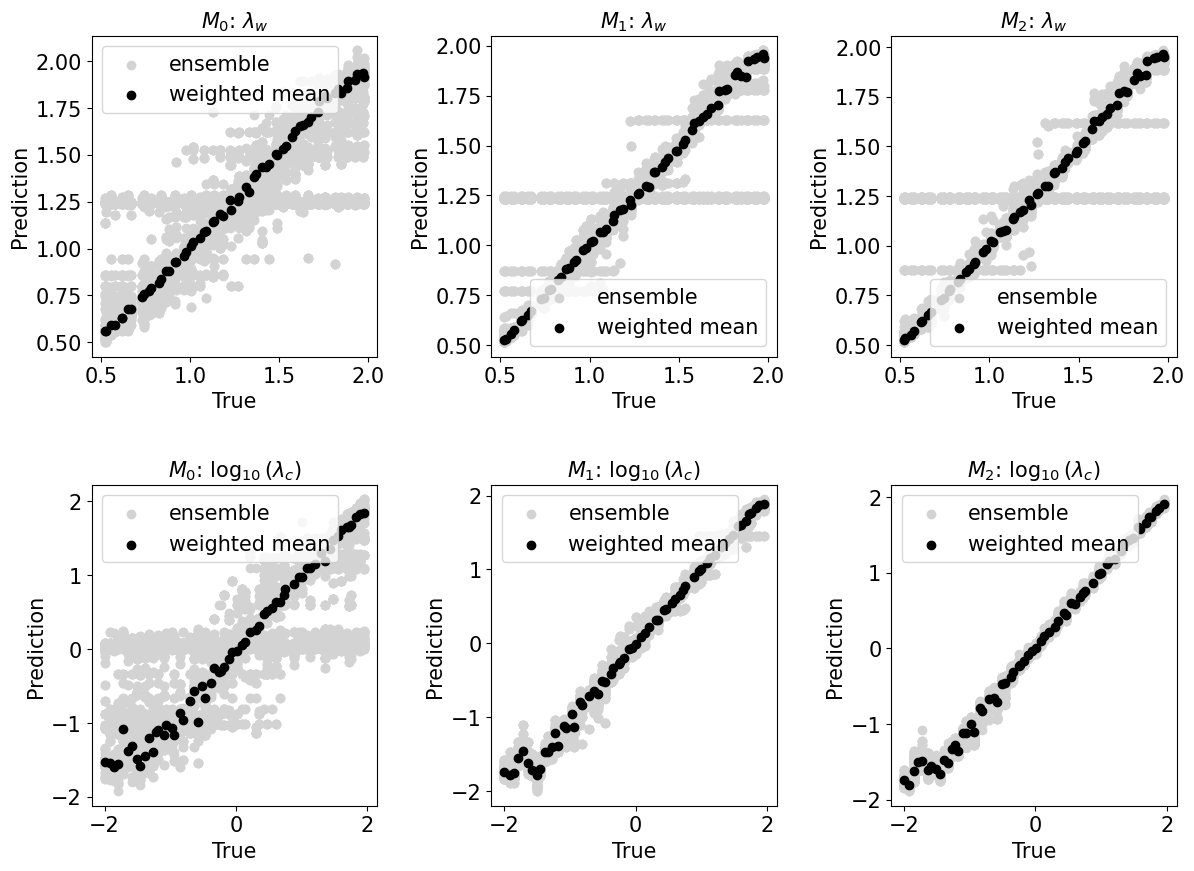

In [18]:
train_or_test = 'test'
fig, axes = plt.subplots(2,3,figsize=(14,10))
for i in range(2):
    y_var = y_vars[i]
    for j in range(3):
        model = labels[j]
        r = results[model]
        ax = axes[i,j]
        plot_1to1_scatter(r, ax=ax, iy=i, train_or_test='test', model=model, y_var=y_var)

plt.subplots_adjust(hspace=0.4, wspace=0.4)


## Performance versus true (with uncertainty)

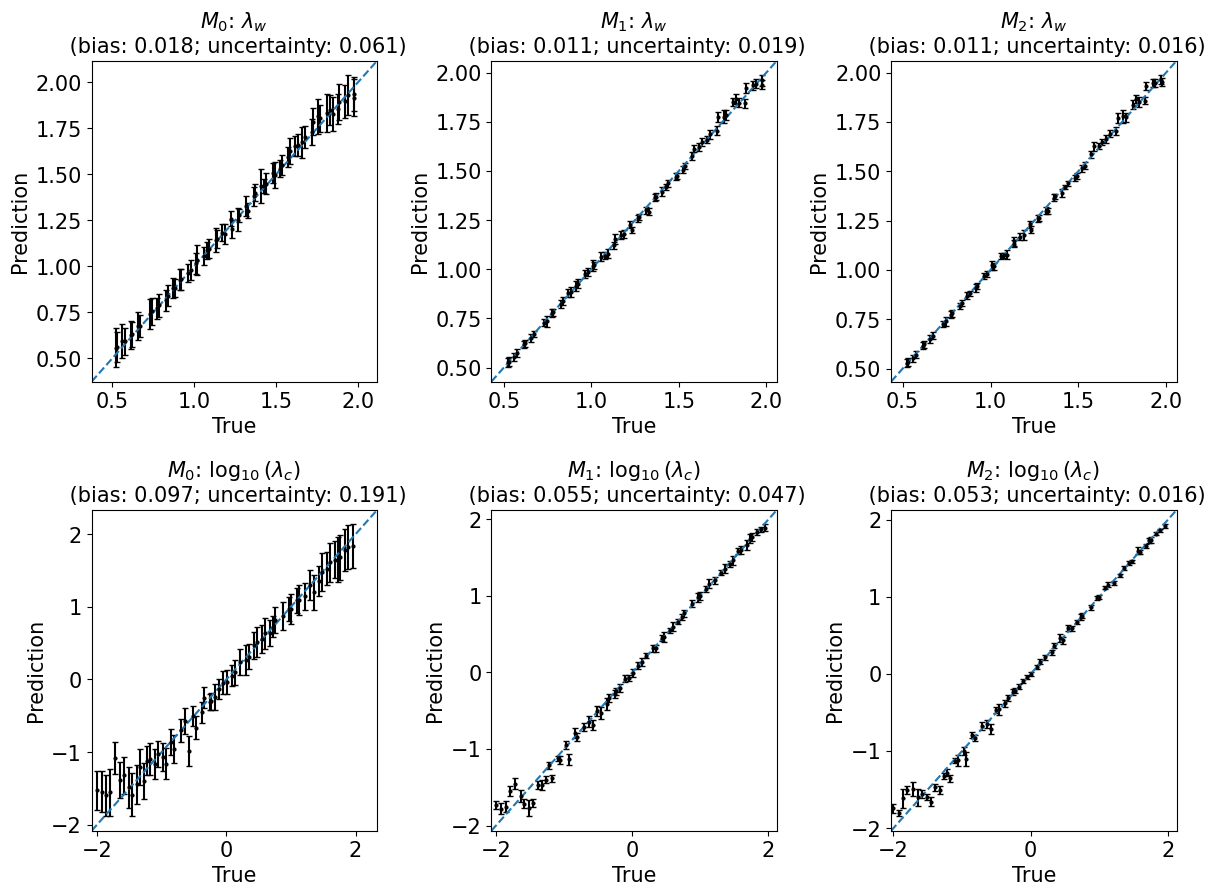

In [21]:
train_or_test = 'test'
fig, axes = plt.subplots(2,3,figsize=(14,10))
for i in range(2):
    y_var = y_vars[i]
    for j in range(3):
        model = labels[j]
        r = results[model]
        ax = axes[i,j]
        plot_1to1_uncertainty(r, iy=i, ax=ax, train_or_test=train_or_test, model=model, y_var=y_var)

plt.subplots_adjust(hspace=0.4, wspace=0.4)


# Backup plots: Plots specific to cloud chamber system

In [14]:
# Let's make a big pandas dataframe
loc = [int(xv.split('_')[0][1:]) for xv in x_vars]
time = [int(xv.split('_')[1][1:]) for xv in x_vars]
varn = [xv.split('_')[2] for xv in x_vars]
df_sen = pd.DataFrame()
df_sen['loc']  = loc
df_sen['time'] = time
df_sen['varn'] = varn
for i,yvarn in enumerate(y_vars):
    df_sen[yvarn] = data.sensitivity[:,i]
    df_sen[yvarn+"_mask"] = data.sensitivity_mask[:,i]
    df_sen[yvarn+"_condmask"] = data.cond_sensitivity_mask[:,i]    

varn_set = sorted(list(set(varn)))
time_set = sorted(list(set(time)))
loc_set = sorted(list(set(loc)))

# Set up the gradual changing color lines
# cmap = plt.cm.gist_rainbow  # You can choose other colormaps like 'plasma', 'inferno', 'magma', etc.
# colors = cmap(np.linspace(0, 1, len(loc_set)))

cmap1 = plt.cm.Blues_r
colors1 = cmap1(np.linspace(0.2, 0.8, 9))
cmap2 = plt.cm.Oranges_r
colors2 = cmap2(np.linspace(0.2, 0.8, 9))
cmap3 = plt.cm.Greys_r
colors3 = cmap3(np.linspace(0.2, 0.8, 9))
colors = np.concat([colors1, colors2, colors3])


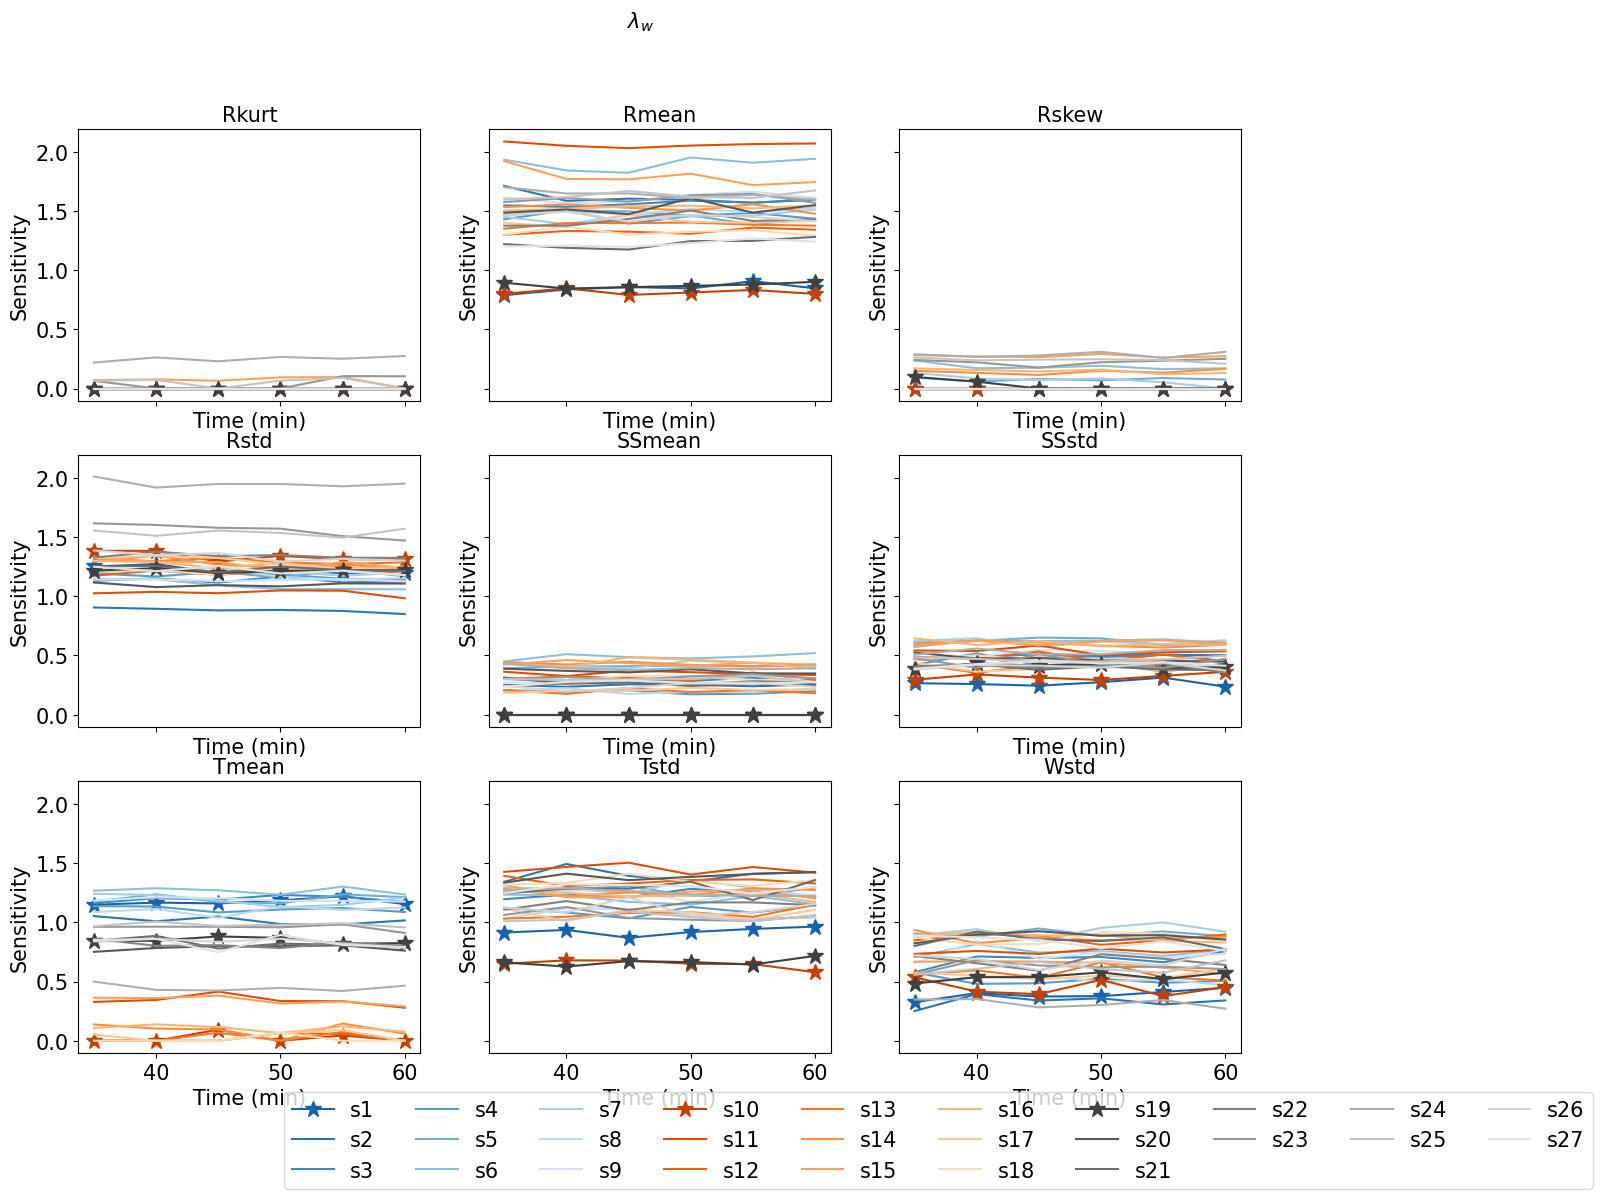

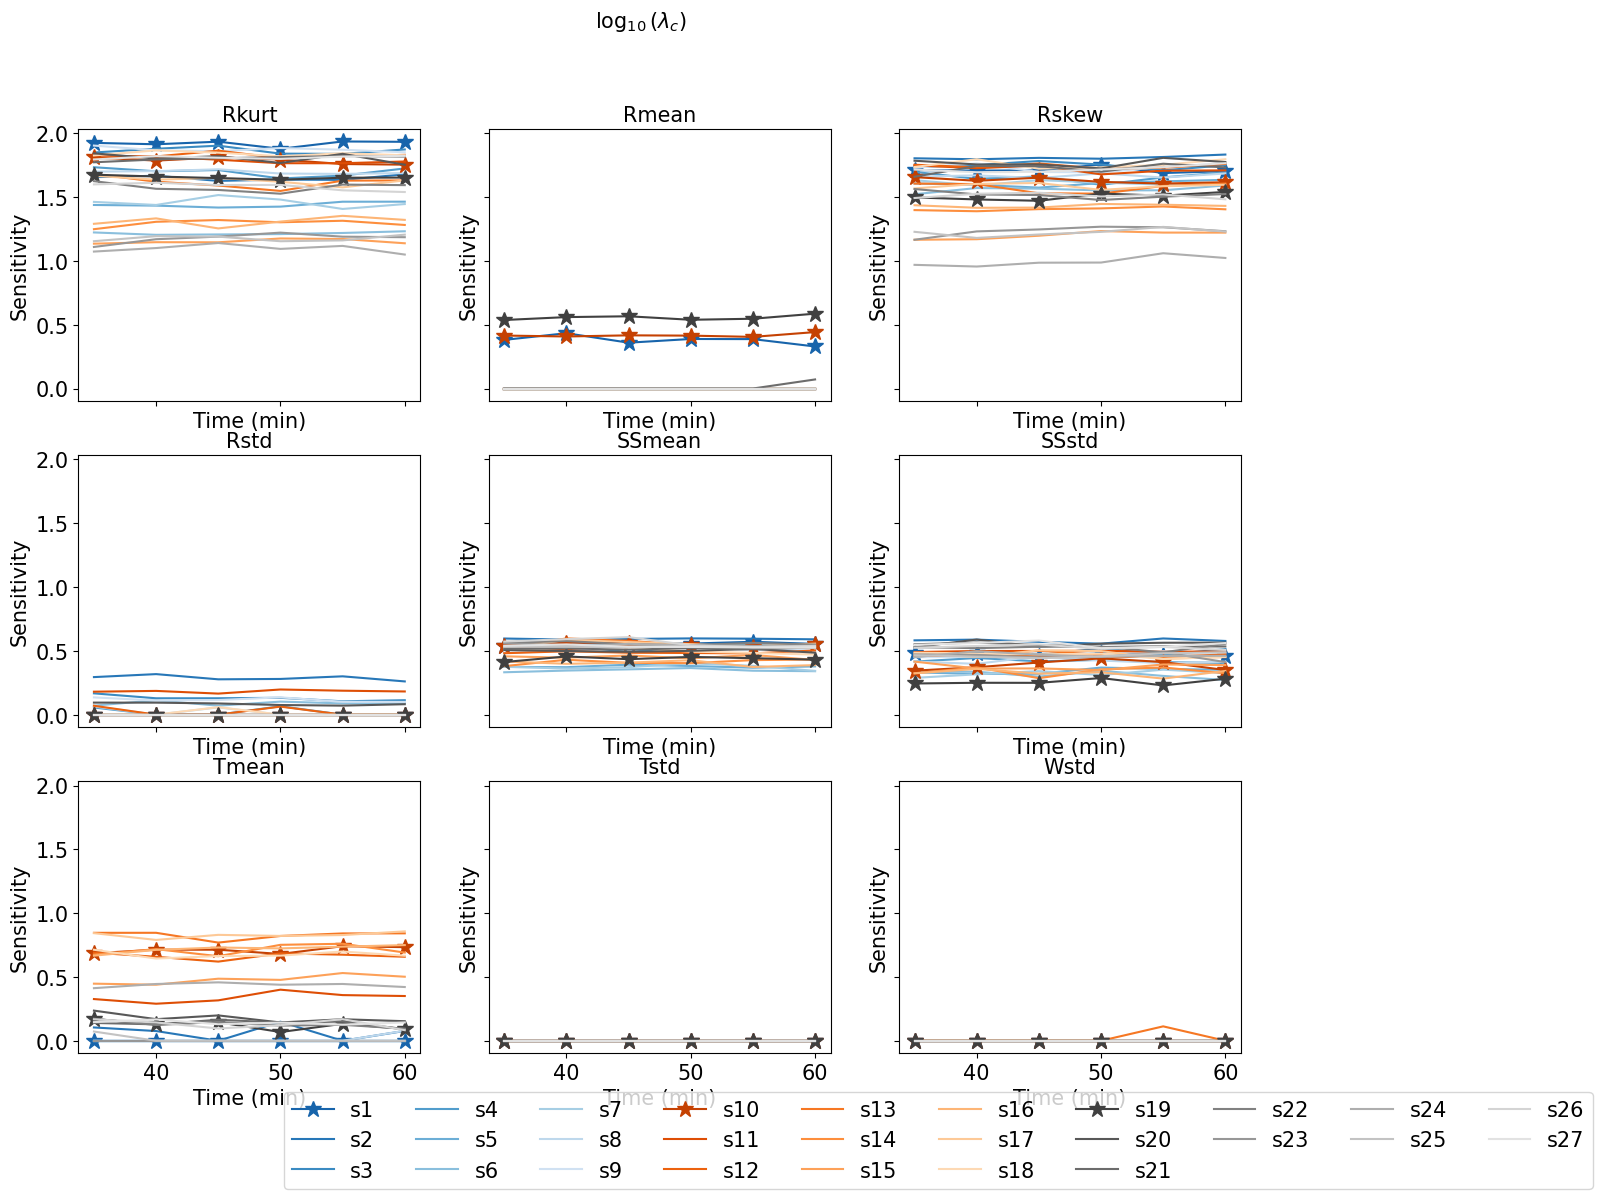

In [15]:
# Plot -- sensitivity only
for k,yvarn in enumerate(y_vars):
    fig, axes = plt.subplots(3, 3, figsize=(15,12), sharex=True, sharey=True)
    axes = axes.flatten()
    for i,varn in enumerate(varn_set):
        ax = axes[i]
        for j,loc in enumerate(loc_set):
            df = df_sen[(df_sen['varn']==varn) & (df_sen['loc']==loc)]
            t, d = df['time'].values, df[yvarn].values
            if loc in [1, 10, 19]:
                ax.plot(t, d, '-*', label=f"s{loc}", markersize=12, color=colors[j])
            else:
                ax.plot(t, d, label=f"s{loc}", color=colors[j])
        ax.set(title=varn, xlabel='Time (min)', ylabel='Sensitivity')
    ax.legend(loc=[-1.8, -0.5], ncols=10)
    plt.suptitle(yvarn)


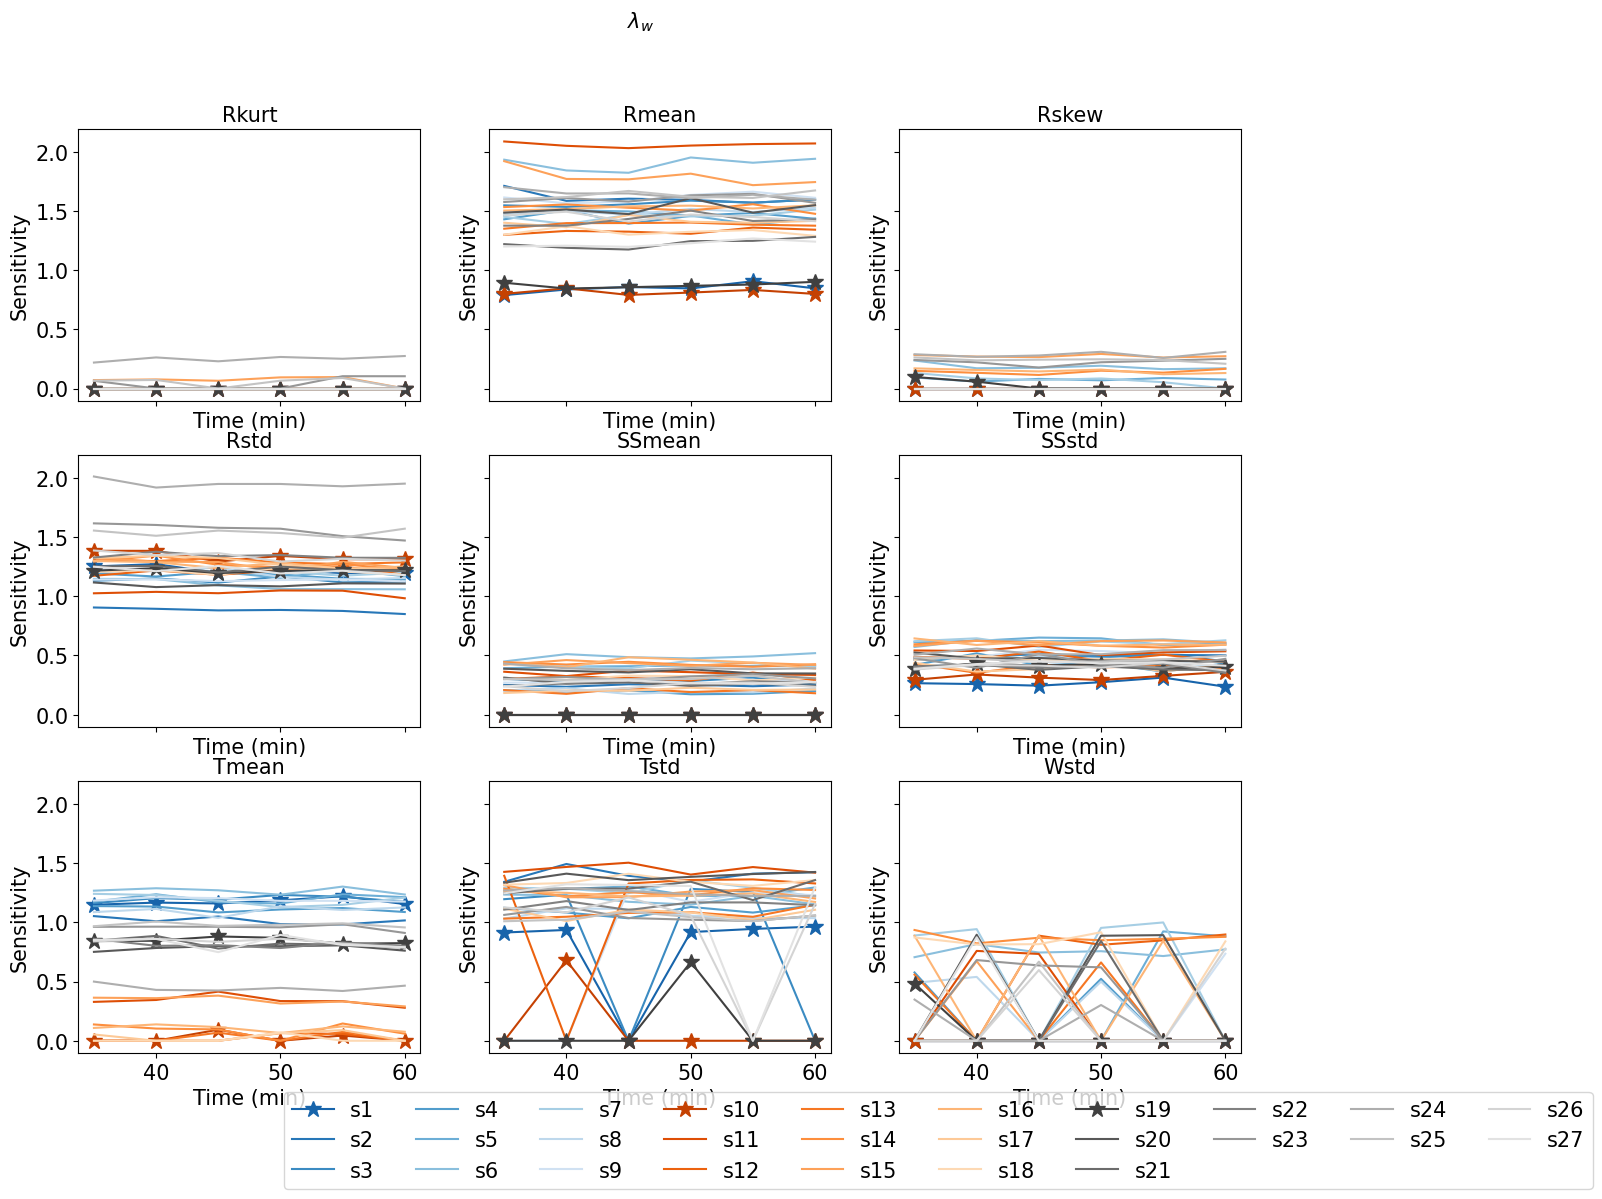

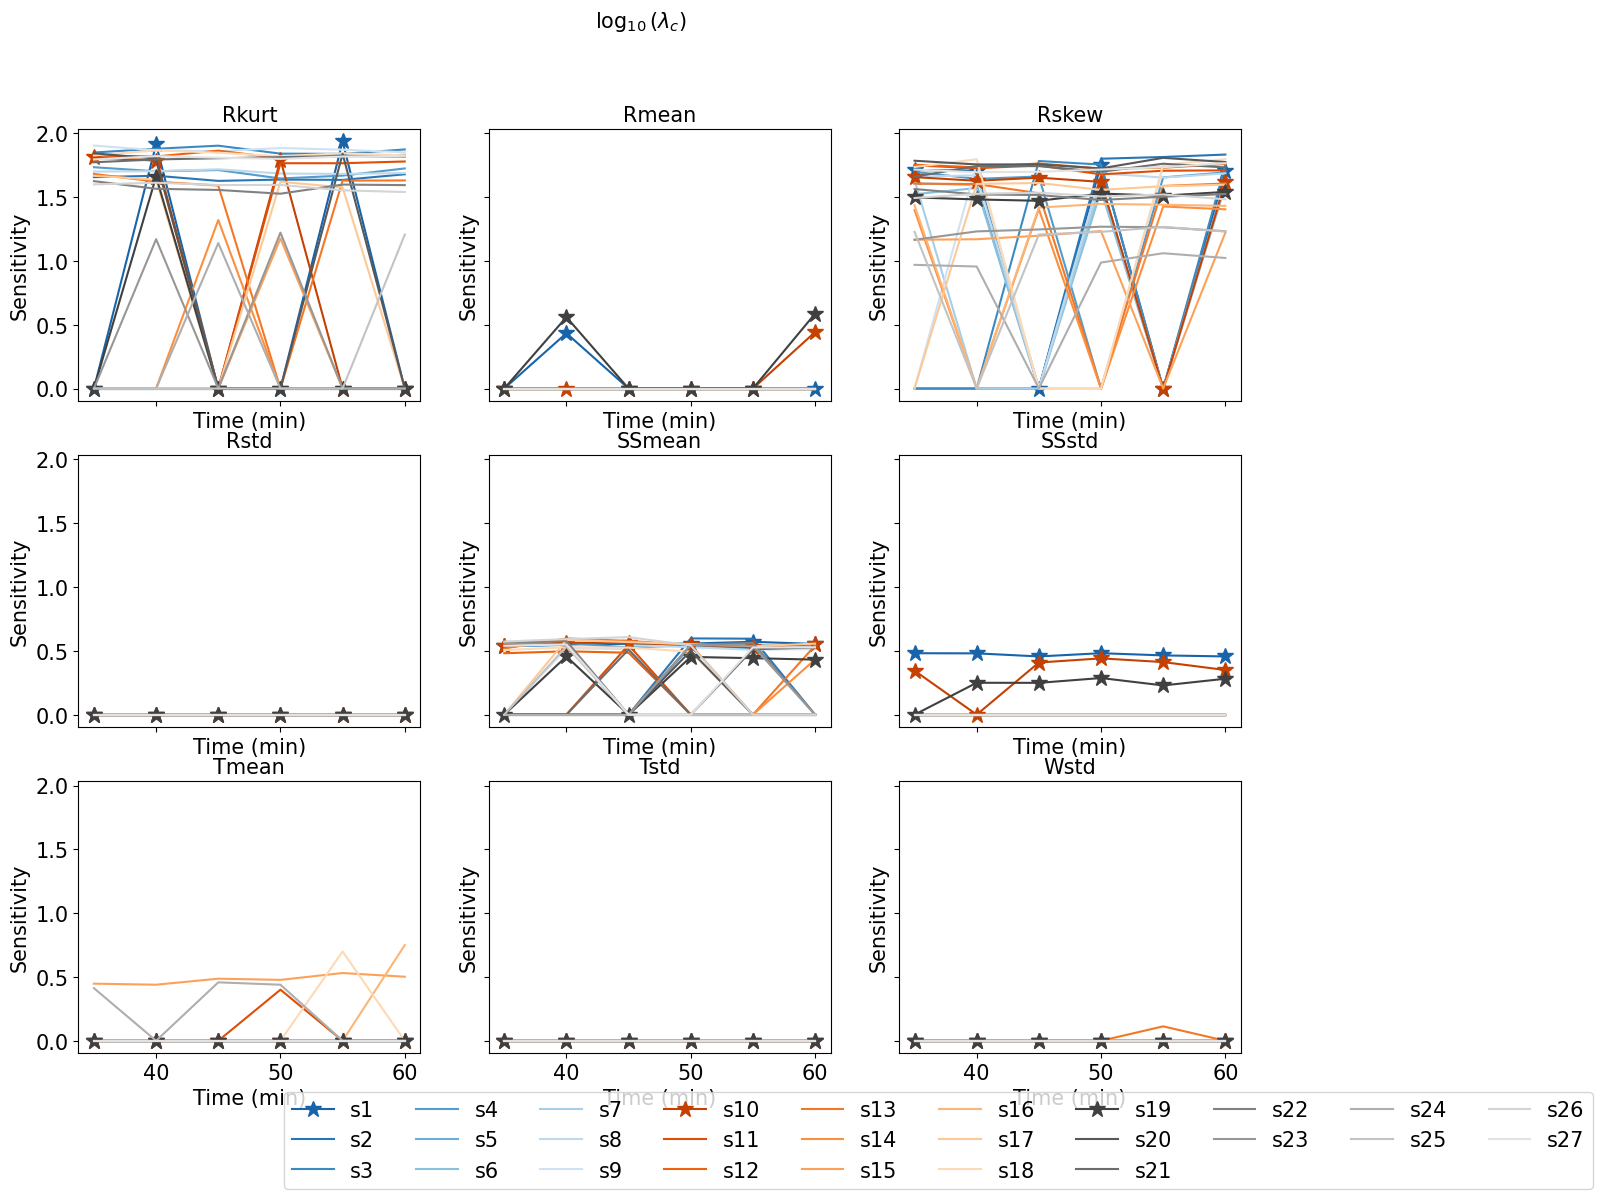

In [16]:
# Plot -- sensitivity filtered by conditional mask
for k,yvarn in enumerate(y_vars):
    fig, axes = plt.subplots(3, 3, figsize=(15,12), sharex=True, sharey=True)
    axes = axes.flatten()
    for i,varn in enumerate(varn_set):
        ax = axes[i]
        for j,loc in enumerate(loc_set):
            df = df_sen[(df_sen['varn']==varn) & (df_sen['loc']==loc)].copy()
            t, d = df['time'].values, df[yvarn].values
            m = df[yvarn+'_condmask']
            d[~m] = 0 
            if loc in [1, 10, 19]:
                ax.plot(t, d, '-*', label=f"s{loc}", markersize=12, color=colors[j])
            else:
                ax.plot(t, d, label=f"s{loc}", color=colors[j])
        ax.set(title=varn, xlabel='Time (min)', ylabel='Sensitivity')
    ax.legend(loc=[-1.8, -0.5], ncols=10)
    plt.suptitle(yvarn)
